# Q2: Lets go deeper! CaffeNet for PASCAL classification (20 pts)

**Note:** You are encouraged to reuse code from the previous task. Finish Q1 if you haven't already!


As you might have seen, the performance of the SimpleCNN model was pretty low for PASCAL. This is expected as PASCAL is much more complex than FASHION MNIST, and we need a much beefier model to handle it.

In this task we will be constructing a variant of the [AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf) architecture, known as CaffeNet. If you are familiar with Caffe, a prototxt of the network is available [here](https://github.com/BVLC/caffe/blob/master/models/bvlc_reference_caffenet/train_val.prototxt). A visualization of the network is available [here](http://ethereon.github.io/netscope/#/preset/caffenet).


## 2.1 Build CaffeNet (5 pts)
Here is the exact model we want to build. In this task, `torchvision.models.xxx()` is NOT allowed. Define your own CaffeNet! We use the following operator notation for the architecture:
1. Convolution: A convolution with kernel size $k$, stride $s$, output channels $n$, padding $p$ is represented as $conv(k, s, n, p)$.
2. Max Pooling: A max pool operation with kernel size $k$, stride $s$ as $maxpool(k, s)$.
3. Fully connected: For $n$ output units, $FC(n)$.
4. ReLU: For rectified linear non-linearity $relu()$

```
ARCHITECTURE:
-> image
-> conv(11, 4, 96, ’VALID’)
-> relu()
-> max_pool(3, 2)
-> conv(5, 1, 256, 'SAME')
-> relu()
-> max_pool(3, 2)
-> conv(3, 1, 384, 'SAME')
-> relu()
-> conv(3, 1, 384, 'SAME')
-> relu()
-> conv(3, 1, 256, ’SAME’)
-> relu()
-> max_pool(3, 2)
-> flatten()
-> fully_connected(4096)
-> relu()
-> dropout(0.5)
-> fully_connected(4096)
-> relu()
-> dropout(0.5)
-> fully_connected(20)
```

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import trainer
from utils import ARGS
from simple_cnn import SimpleCNN
from voc_dataset import VOCDataset


class CaffeNet(nn.Module):
    def __init__(self, num_classes=20, inp_size=224, c_dim=3):
        super().__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(in_channels=c_dim, out_channels=96, kernel_size=11, stride=4, padding='valid')
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding='same')
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding='same')
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding='same')
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding='same')
        self.nonlinear = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=2)

        self.flat_dim = 256 * 5 * 5
        self.fc6 = nn.Sequential(nn.Linear(self.flat_dim, 4096), nn.ReLU(), nn.Dropout(0.5))
        self.fc7 = nn.Sequential(nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5))
        self.fc8 = nn.Sequential(nn.Linear(4096, num_classes))
    
    def forward(self, x):
        N = x.size(0)
        x = self.conv1(x)
        x = self.nonlinear(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.nonlinear(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.nonlinear(x)
        x = self.conv4(x)
        x = self.nonlinear(x)

        x = self.conv5(x)
        x = self.nonlinear(x)
        x = self.pool5(x)

        flat_x = x.view(N, self.flat_dim)
        out = self.fc6(flat_x)
        out = self.fc7(out)
        out = self.fc8(out)

        return out


## 2.2 Save the Model (5 pts)
Fill out `save_model()` in `trainer.py` to save the checkpoints of the model periodically. **You will need these models later.**


## 2.3 Train and Test (5pts)
Show clear screenshots of testing MAP and training loss for 50 epochs. The final MAP should be at least around 0.4. Please evaluate your model to calculate the MAP on the testing dataset every 250 iterations. Use the following hyperparamters:
* batch_size=32
* Adam optimizer with lr=0.0001

**NOTE: SAVE AT LEAST 5 EVENLY SPACED CHECKPOINTS DURING TRAINING (1 at end)**

In [3]:
args = ARGS(epochs=50, lr=0.0001, batch_size=32, save_at_end=True, save_freq=10, step_size=30, test_batch_size=128, use_cuda=True, gamma=0.1, val_every=250)
print(args)
model = CaffeNet()
optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)
test_ap, test_map = trainer.train(args, model, optimizer, scheduler, model_name='caffenet3')
print('test map:', test_map)

args.batch_size = 32
args.device = cuda
args.epochs = 50
args.gamma = 0.1
args.inp_size = 224
args.log_every = 100
args.lr = 0.0001
args.save_at_end = True
args.save_freq = 10
args.step_size = 30
args.test_batch_size = 128
args.val_every = 250

Train Epoch: 0 [0 (0%)]	Loss: 0.692065
Train Epoch: 0 [100 (64%)]	Loss: 0.229759
Train Epoch: 1 [200 (27%)]	Loss: 0.234384
Train Epoch: 1 [300 (91%)]	Loss: 0.239146
Train Epoch: 2 [400 (55%)]	Loss: 0.203960
Train Epoch: 3 [500 (18%)]	Loss: 0.237984
Train Epoch: 3 [600 (82%)]	Loss: 0.225359
Train Epoch: 4 [700 (46%)]	Loss: 0.228667
Train Epoch: 5 [800 (10%)]	Loss: 0.231692
Train Epoch: 5 [900 (73%)]	Loss: 0.221244
Train Epoch: 6 [1000 (37%)]	Loss: 0.217274
Train Epoch: 7 [1100 (1%)]	Loss: 0.207280
Train Epoch: 7 [1200 (64%)]	Loss: 0.207746
Train Epoch: 8 [1300 (28%)]	Loss: 0.198039
Train Epoch: 8 [1400 (92%)]	Loss: 0.191352
Train Epoch: 9 [1500 (55%)]	Loss: 0.204181
Train Epoch: 10 [1600 (19%)]	Loss: 0.222830
Train Epoch: 10 [1700 (83%)]	Loss: 0.

**INSERT YOUR TENSORBOARD SCREENSHOTS HERE**

***Loss for training***

<img src="vlr-hw1-images/q2-loss.png"/>


***mAP for testing*** 

<img src="vlr-hw1-images/q2-map.png"/>

## 2.4 Visualizing: Conv-1 filters (5pts)
Extract and compare the weights of conv1 filters at different stages of the training (at least from 5 different epochs).

- Write a function to load your model checkpoints.
- Get the weights for conv1 from the loaded model.
- Visualize the weights using the following vis() function.

Sometimes the filters all look very random and may not change too much across epochs. Don't worry! You will get full credits as long as the code is correct.

In [2]:
import numpy as np
from PIL import Image

# This function plots all the filters in one image. 
def vis(conv1):
    assert type(conv1) == np.ndarray
    assert conv1.shape == (11, 11, 3, 96)
    im = np.zeros((120, 120, 3))
    step_size = 12
    column = 0
    row = 0
    for k in range(conv1.shape[3]):
        this_filter = conv1[:, :, :, k]
        im[column*step_size:column*step_size+11, row*step_size:row*step_size+11, :] = this_filter
        column = column + 1
        if column == 10:
            column = 0
            row = row + 1
    image = Image.fromarray(np.uint8((im-np.mean(im))/np.std(im)))
    # image.show()
    return image

(-0.5, 119.5, 119.5, -0.5)

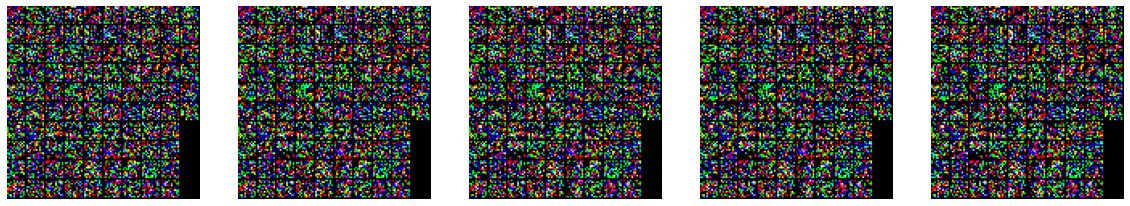

In [15]:
# Write your code here to get the conv1 filters for each epoch
# conv1s = [np.random.randn(11, 11, 3, 96)]
model = CaffeNet()
args = ARGS()
args.use_cuda = True    
# epoch = 5
model_name='caffenet3'
epochs = [10,20,30,40,50]
img=[]
for epoch in epochs:
        filename = 'model_params/checkpoint-{}-epoch{}.pth'.format(
                model_name, epoch)
        # path = 'model_params/checkpoint-{}-epoch{}.pth'.format('caffenet', epoch)
        # print(filename)
        model.load_state_dict(torch.load(filename, map_location=args.device))
        conv1 = model.state_dict()['conv1.weight']
        conv1 = torch.permute(conv1, (2,3,1,0)).numpy()
        # For each epoch, use vis() to visualize the filters.
        # Before passing the weights into vis(), make sure it is an numpy array with shape (11, 11, 3, 96).
        # You may need torch.permute to reorganize the dimensions.
        img.append(vis(conv1))
        
f, axarr = plt.subplots(1, 5,figsize=(20,20))
plt.axis('off')
axarr[0].imshow(img[0])
axarr[1].imshow(img[1])
axarr[2].imshow(img[2])
axarr[3].imshow(img[3])
axarr[4].imshow(img[4])
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[3].axis('off')
axarr[4].axis('off')